In [1]:
!nvidia-smi  --query-gpu=name,memory.total,memory.used --format=csv,noheader

NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188 MiB, 84 MiB


Coded by B.Heddle, E. Porter and N. Wong

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split,cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

Label_encoder = LabelEncoder()

In [3]:
# Load the train data_trainset
data_train = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_train['gender'] = data_train['gender'].map(gender_conversion)

data_train['name'] = data_train['first'] + " " + data_train['last']
data_train['address'] = data_train['street'] + ", " + data_train['city'] + ", " + data_train['state']

#Convert first name
data_train['first#'] = Label_encoder.fit_transform(data_train['first'])

#Convert last  name
data_train['last#'] = Label_encoder.fit_transform(data_train['last'])

#Convert first name + last name
data_train['name#'] = Label_encoder.fit_transform(data_train['name'])

#data_train['age'] = 2024 - pd.to_numeric(data_train['dob'].str[:4]) 

#Convert Job
data_train['job#'] = Label_encoder.fit_transform(data_train['job'])

data_train['merchant#'] = Label_encoder.fit_transform(data_train['merchant'])

data_train['category#'] = Label_encoder.fit_transform(data_train['category'])


data_train['street#'] = Label_encoder.fit_transform(data_train['street'])
data_train['city#'] = Label_encoder.fit_transform(data_train['city'])
data_train['state#'] = Label_encoder.fit_transform(data_train['state'])

data_train['address#'] = Label_encoder.fit_transform(data_train['address'])

data_train['trans_num'] = Label_encoder.fit_transform(data_train['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_train['age'] = data_train['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_train['distance_km'] = haversine(data_train['lat'], data_train['long'], data_train['merch_lat'], data_train['merch_long'])


data_train = data_train.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
#data_train = data_train.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_train.head()

,cc_num,merchant,category,amt,gender,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,1,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,0,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,0,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,1,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,1,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


In [4]:
# Load the test dataset
data_test = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)


#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_test['gender'] = data_test['gender'].map(gender_conversion)

data_test['name'] = data_test['first'] + " " + data_test['last']
data_test['address'] = data_test['street'] + ", " + data_test['city'] + ", " + data_test['state']

#Convert first name
data_test['first#'] = Label_encoder.fit_transform(data_test['first'])

#Convert last  name
data_test['last#'] = Label_encoder.fit_transform(data_test['last'])

#Convert first name + last name
data_test['name#'] = Label_encoder.fit_transform(data_test['name'])

#data_test['age'] = 2024 - pd.to_numeric(data_test['dob'].str[:4]) 

#Convert Job
data_test['job#'] = Label_encoder.fit_transform(data_test['job'])

data_test['merchant#'] = Label_encoder.fit_transform(data_test['merchant'])

data_test['category#'] = Label_encoder.fit_transform(data_test['category'])


data_test['street#'] = Label_encoder.fit_transform(data_test['street'])
data_test['city#'] = Label_encoder.fit_transform(data_test['city'])
data_test['state#'] = Label_encoder.fit_transform(data_test['state'])

data_test['address#'] = Label_encoder.fit_transform(data_test['address'])

data_test['trans_num'] = Label_encoder.fit_transform(data_test['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_test['age'] = data_test['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_test['distance_km'] = haversine(data_test['lat'], data_test['long'], data_test['merch_lat'], data_test['merch_long'])


data_test = data_test.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
#data_test = data_test.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_test.head()

,cc_num,merchant,category,amt,gender,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,1,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,0,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,0,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,1,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,1,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defa

Cross-validation Results:
Accuracy: 0.9956 ± 0.0005
Precision: 0.3187 ± 0.1208
Recall: 0.1044 ± 0.1020
F1: 0.1365 ± 0.1032
Roc_auc: 0.8666 ± 0.0251


C:\Users\eporter3\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


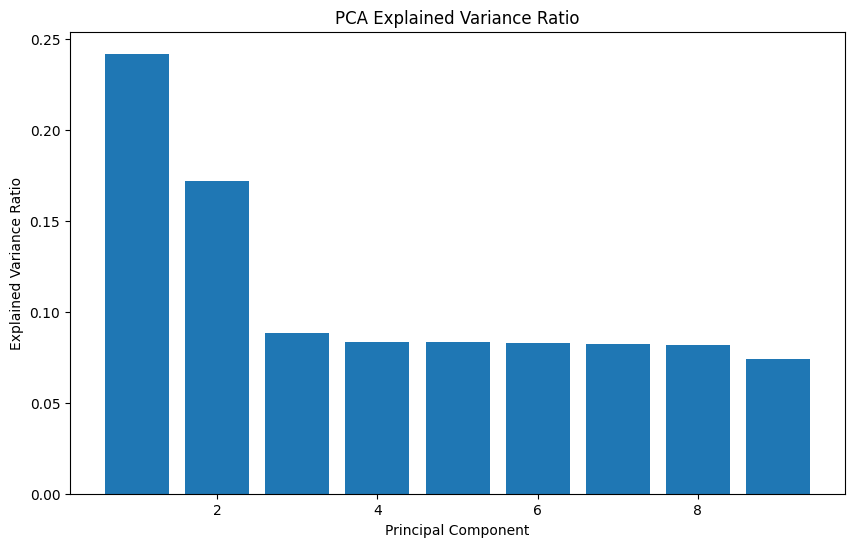

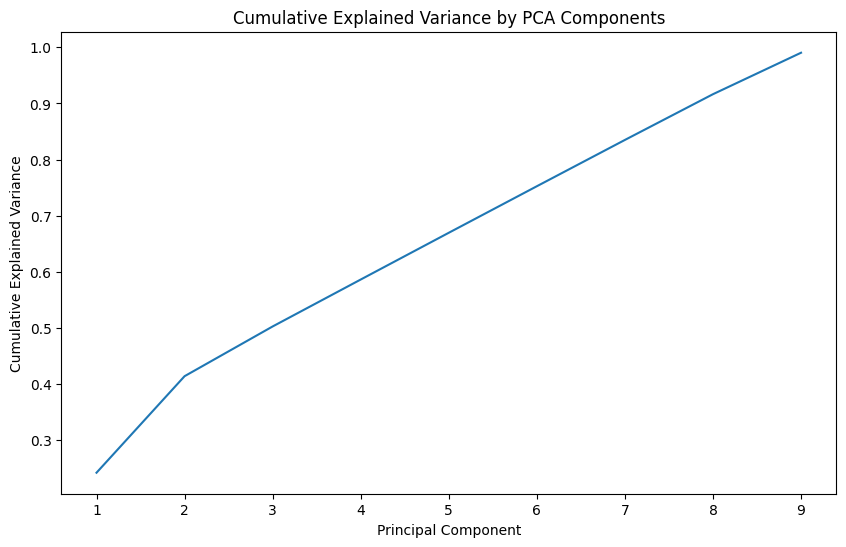

In [5]:
X_train = data_train.drop(columns=['is_fraud'], axis=1)
y_train = data_train['is_fraud']

X_test = data_test.drop(columns=['is_fraud'], axis=1)
y_test = data_test['is_fraud']

# Identify numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))  # PCA with 95% variance retained
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=2) #Depth = 2, 200 weak learners
model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])
# Perform cross-validation
cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring=['precision', 'recall', 'f1', 'accuracy', 'roc_auc'],
    return_train_score=True
)

# Print cross-validation results
print("Cross-validation Results:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print(f"{metric.capitalize()}: {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")

# Train the model
pipeline.fit(X_train, y_train)

# Access the PCA step from the numeric_transformer in the preprocessor pipeline
pca = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['pca']


# Plot the explained variance ratio (the histogram)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# You can also display the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()





In [6]:
# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9979036167559504
AUC Score: 0.9968092999705757

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.86      0.54      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.93      0.77      0.83    555719
weighted avg       1.00      1.00      1.00    555719



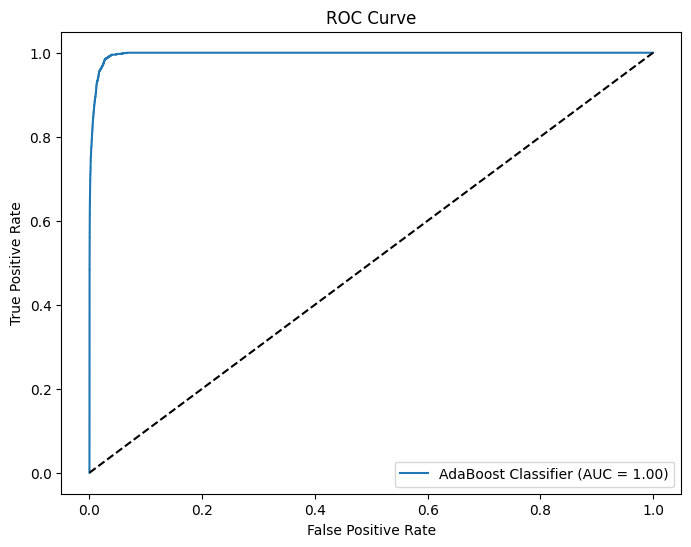

In [7]:

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

           Feature Type  Total Importance
0        PCA Components          0.357371
1  Categorical Features          0.642629


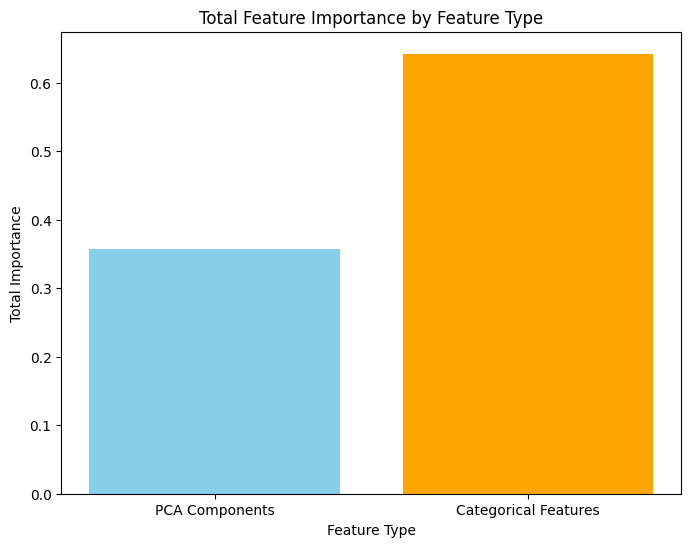

In [8]:
# Access the preprocessor and AdaBoost model
preprocessor = pipeline.named_steps['preprocessor']
adaboost_model = pipeline.named_steps['classifier']

# Get PCA component count and create PCA feature names
pca = preprocessor.named_transformers_['num'].named_steps['pca']
pca_feature_names = [f'PCA_Component_{i + 1}' for i in range(pca.n_components_)]

# Get one-hot encoded feature names for categorical features
onehot_categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combined feature names after preprocessing
all_feature_names = np.concatenate([pca_feature_names, onehot_categories])

# Feature importances
feature_importances = adaboost_model.feature_importances_

# Ensure lengths match
assert len(all_feature_names) == len(feature_importances), (
    f"Mismatch: {len(all_feature_names)} feature names vs {len(feature_importances)} importances."
)

# Create a DataFrame for analysis
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Since PCA changes the numeric features, categorize them as 'PCA Components'
pca_importance_total = feature_importance_df[
    feature_importance_df['Feature'].str.contains('PCA_Component')
]['Importance'].sum()

categorical_importance_total = feature_importance_df[
    feature_importance_df['Feature'].isin(onehot_categories)
]['Importance'].sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Feature Type': ['PCA Components', 'Categorical Features'],
    'Total Importance': [pca_importance_total, categorical_importance_total]
})

# Display the summary
print(summary_df)

# Plot the total importance by feature type
plt.figure(figsize=(8, 6))
plt.bar(summary_df['Feature Type'], summary_df['Total Importance'], color=['skyblue', 'orange'])
plt.xlabel('Feature Type')
plt.ylabel('Total Importance')
plt.title('Total Feature Importance by Feature Type')
plt.show()
